In [1]:
import sys
sys.path.append('../data')
sys.path.append('../data/low')
sys.path.append('../data/mid')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

## **archivos**

In [6]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

In [7]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

file10_080124.mat


file11_080124.mat
file12_080124.mat
file13_080124.mat
file15_080124.mat
file16_080124.mat
file17_080124.mat
file18_080124.mat
file1_050124.mat
file1_080124.mat
file2_050124.mat
file3_080124.mat
file7_080124.mat
file8_080124.mat
file9_080124.mat
low1_100124.mat
low2_100124.mat
low3_100124.mat
low5_100124.mat


In [8]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    print(i)
    taus.append(aux.get_tau()[1])
    print(i)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18


## **psd defectos, sin interpolación**
Sin defectos, no hay trato de información perdida

In [9]:
signal_sin_defectos = []
hilbert_sin_defectos = []

for i, df in enumerate(defectos_frames):

    aux,aux_hilbert= df.get_no_defectos()
    signal_sin_defectos.append(aux)
    hilbert_sin_defectos.append(aux_hilbert)
    sys.stdout.write(str(i) + '\r')



In [10]:
signal_sin_defectos[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j
...,...,...,...,...
599995,0.176268,0.058256,0.000015,0.000015+0.000493j
599996,0.177254,0.059242,0.000033,0.000033+0.000343j
599997,0.179227,0.061215,0.000050,0.000050+0.001284j
599998,0.179885,0.061872,0.000066,0.000066+0.001095j


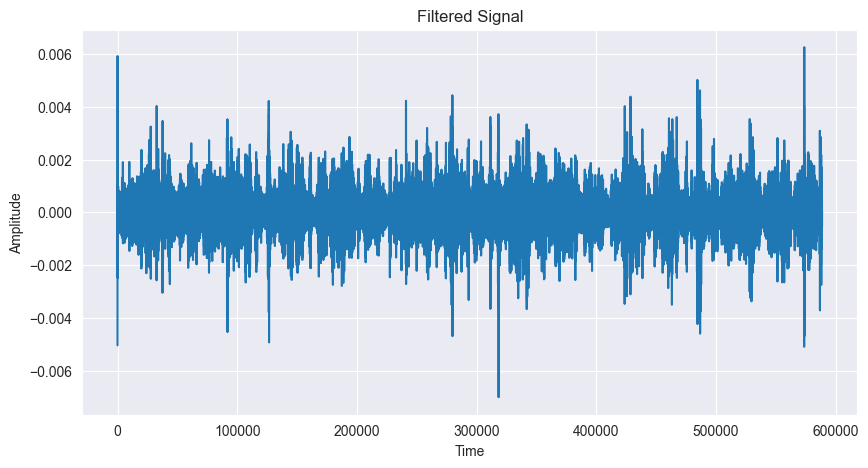

In [11]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and the sampling frequency
cutoff_freq = 200  # Specify the cutoff frequency in Hz
sampling_freq = 1000  # Specify the sampling frequency in Hz

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = cutoff_freq / (sampling_freq / 2)

# Design the filter coefficients using a Butterworth filter
order = 4  # Specify the filter order
b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)

# Apply the filter to the signal
signal_filtered = []
for elem in signal_sin_defectos:
    elem = elem.dropna()
    aux = filtfilt(b, a, elem['Filtered Signal'])
    signal_filtered.append(aux)


# Plot the filtered signal
plt.figure(figsize=(10, 5))
plt.plot(signal_filtered[0], label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [25]:
def create_windows(df, size = 4000, overlap = 500):
    num_windows = (len(df) - size) // (size - overlap) + 1
    windows = []
    for i in range(num_windows):
        start = i * (size - overlap)
        end = start + size
        window = df.iloc[start:end]
        windows.append(window)
    return windows

In [12]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

In [26]:
frames_windows = []
for i, df in enumerate(signal_sin_defectos):
    aux =  create_windows(df, 2000, 200)
    frames_windows.append(aux)
    sys.stdout.write(str(i) + '\r')


In [49]:
all_psd = []
all_freqs = []

for i, df in enumerate(frames_windows):
    aux = []
    aux2 = []
    for elem in df:
        freqs, psd = ffts(elem)
        aux.append(psd)
        aux2.append(freqs)

    all_psd.append(aux)
    all_freqs.append(aux2)

    sys.stdout.write(str(i) + '\r')

In [50]:
mean_fourier = []
mean_freqs = []
for i, df in enumerate(all_psd):
    aux = []
    aux2 = []
    for elem in df:
        aux.append(np.mean(elem))
        aux2.append(np.mean(all_freqs[i]))

    mean_fourier.append(aux)
    mean_freqs.append(aux2)
    sys.stdout.write(str(i) + '\r')

In [54]:
mean_fourier2 = []
for elem in mean_fourier:
    aux = np.where(np.isnan(elem), 0, elem)
    mean_fourier2.append(aux)

In [51]:
mean_fourier = np.array(mean_fourier)
mean_fourier.shape

(19, 333)

In [ ]:
for i, elem in enumerate(mean_fourier2):
    figure = plt.figure(figsize=(10,5))
    #elem = elem.dropna()
    #freq1, psd1 = ffts(elem['Filtered Signal'], fs=1000)
    freq2, psd2 = ffts(frames[i]['Filtered Signal'])

    plt.loglog(mean_freqs[i], elem , label = 'sin defectos', alpha = 0.7)
    plt.loglog(freq2,psd2, label = 'con defectos', alpha = 0.5)

    plt.title(f"PSD - Muestra {i}")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

In [ ]:
hilbert_sin_defectos[0].columns

Index(['Hilbert Transform', 'Amplitude', 'Instantaneous Phase',
       'Gradient Phase'],
      dtype='object')

### **welch**

In [59]:
x_sd = []
x_defectos = []

freqs_sd = []
freqs_defectos = []

x_amp =[]
freqs_amp = []



for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    hilbert_sin_defectos[i] = hilbert_sin_defectos[i].dropna()
    f, pxx = signal.welch(elem['Filtered Signal'], fs =1000, nperseg= 2000 , scaling='spectrum')
    f2, pxx2 = signal.welch(frames[i]['Filtered Signal'], 1000, nperseg= 2000, scaling='spectrum')
    f3, pxx3 = signal.welch(hilbert_sin_defectos[i]['Amplitude'], 1000, nperseg= 2000, scaling='spectrum')
    f4, pxx4 = signal.welch(hilbert_sin_defectos[i]['Amplitude'], 1000, nperseg= 2000, scaling='spectrum')

    x_sd.append(pxx)
    x_defectos.append(pxx2)
    x_amp.append(pxx3)

    freqs_sd.append(f)
    freqs_defectos.append(f2)
    freqs_amp.append(f3)

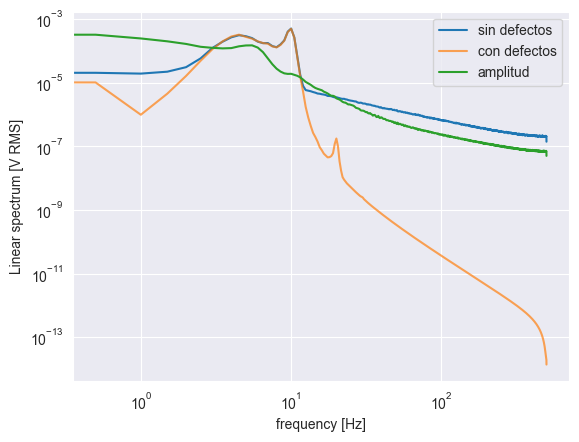

In [60]:
plt.figure()
plt.loglog(freqs_sd[14], np.sqrt(x_sd[14]), label = 'sin defectos')
plt.loglog(freqs_defectos[14], np.sqrt(x_defectos[14]), label = 'con defectos', alpha = 0.7)
plt.loglog(freqs_amp[14], np.sqrt(x_amp[14]), label = 'amplitud sin defectos')
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.legend()
plt.show()

### **espectograma**

In [61]:
S_sd =[]
f_sd = []
t_sd = []

S_cd = []
f_cd = []
t_cd = []

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    f, t, Sxx = signal.spectrogram(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, t2, Sxx2 = signal.spectrogram(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    S_sd.append(Sxx)
    f_sd.append(f)
    t_sd.append(t)

    S_cd.append(Sxx2)
    f_cd.append(f2)
    t_cd.append(t2)


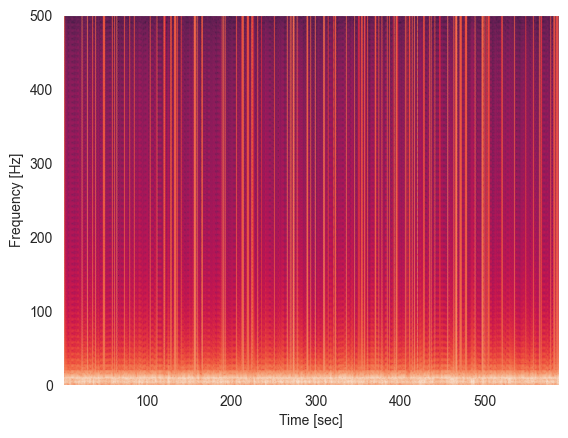

In [62]:
plt.pcolormesh(t_sd[0], f_sd[0], S_sd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

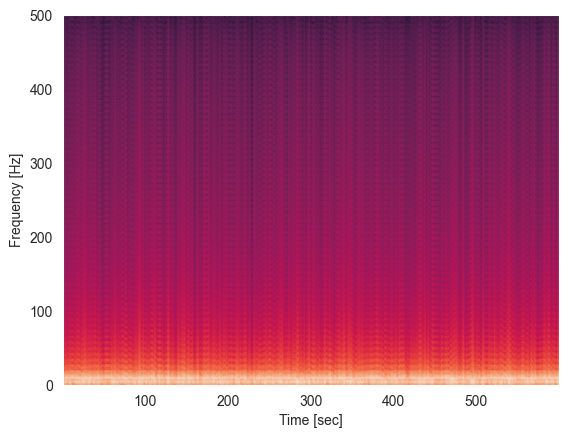

In [63]:
plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## **stats**

In [64]:
all_taus = pd.concat(taus).reset_index(drop=True)
all_taus.describe()

,duration,tau,app_time
count,1938.000000,1938.000000,1919.000000
mean,23.024768,12.542828,5721.947890
std,2.981860,1.702278,8811.733348
min,10.000000,10.000000,1.000000
25%,21.000000,12.000000,851.000000
50%,22.000000,12.000000,2810.000000
75%,25.000000,12.000000,6988.500000
max,29.000000,26.000000,138061.000000


**para espectro y pds**
* tomar ventanas de 2 segundos, 2k muestras y a eso sacar el espectro de potencia y el espectograma y promediarlos para ver su diferencia con el espectograma y el espectro de potencia de la señal completa.

**finalizar tesis**
* entrenar algoritmo de clasificación para encontrar los defectos en otros lados
* entrenar algoritmo de predicción

**otras cosas que usar**
* caracterizar la señal bruta y la señal sin defecto. Estudiar espectro, psd, etc.
* estudiar cosas que digo que son raras, los defectos tiempo vida medio, tiempo entre defecto, si se aumenta la amplitud de la señal, se aumenta la cantidad de defectos, etc.
* agregar un shaker para tener otra señal de referencia y ver si el modelo puede encontrar los defectos en esta nueva señal y si reconoce otras cosas.

In [65]:
fig = go.Figure(data=[go.Histogram(x=all_taus['app_time'])])
fig.update_layout(title='Histogram of Difference', xaxis_title='Difference', yaxis_title='Count')
fig.show()


#### **distribuciones**

In [66]:
appearance_time = all_taus['app_time'].values
appearance_time = (appearance_time[~np.isnan(appearance_time)])


2024-01-11 16:56:08.829 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)


2024-01-11 16:56:10.104 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-01-11 16:56:10.259 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-01-11 16:56:10.397 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-01-11 16:56:10.636 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-01-11 16:56:11.138 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,9.760756e-10,2935.308494,2957.546732,inf,0.044584,9.415907e-04
lognorm,1.818241e-09,2922.420504,2939.099183,inf,0.049685,1.479346e-04
beta,2.285338e-09,4710.504663,4732.742901,inf,0.064534,2.162925e-07
chi2,3.252595e-09,3652.849779,3669.528458,inf,0.051422,7.525382e-05
norm,4.942409e-08,9215.601037,9226.720156,inf,0.258036,3.574926e-113


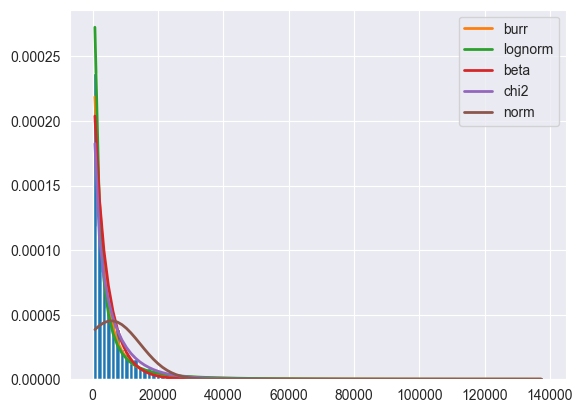

In [67]:
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()


2024-01-11 16:56:12.180 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)


1905


2024-01-11 16:56:13.370 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-01-11 16:56:13.645 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-01-11 16:56:14.236 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-01-11 16:56:14.529 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-01-11 16:56:14.918 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
chi2,7.086617e-09,2546.342704,2562.999416,inf,0.042953,0.001718
gamma,7.834293e-09,2522.961084,2539.617796,inf,0.043088,0.001643
beta,9.133990e-09,2526.164876,2548.373825,inf,0.051037,0.000094
burr,1.253151e-08,2487.372984,2509.581933,inf,0.046666,0.000482
lognorm,1.087952e-07,2662.559877,2679.216589,inf,0.645101,0.000000


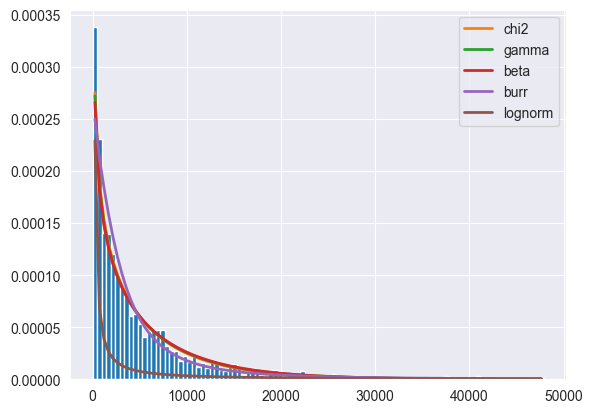

In [68]:
all_taus_2 = all_taus[all_taus['app_time'] <= 50000]
print(len(all_taus_2))

appearance_time = all_taus_2['app_time'].values
appearance_time = appearance_time[~np.isnan(appearance_time)]
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()